In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pickle

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
import sklearn
#from SVM.ipynb import plot_confusion_matrix

import itertools

In [3]:
inspire=pd.read_pickle('bigREFSncgrams.pkl')
refs_of_refs=pd.DataFrame(np.loadtxt('reference_coreness.txt')[:,4:],columns=['core_ref_refs','non-core_ref_refs'])
refs_of_refs.head()

,core_ref_refs,non-core_ref_refs
0,0.00000,0.00000
1,0.00000,0.00000
2,0.00000,0.00000
3,0.03392,0.02365
4,0.44114,0.12174


In [4]:
inspire[['core_ref_refs','non-core_ref_refs']]=refs_of_refs[['core_ref_refs','non-core_ref_refs']]
inspire=inspire[['Text','Result','NC score', 'core refs','non-core refs','core_ref_refs','non-core_ref_refs','Category']]
inspire.head()

,Text,Result,NC score,core refs,non-core refs,core_ref_refs,non-core_ref_refs,Category
0,Comparing Robustness of Pairwise and Multiclas...,0,0,0.000000,0.000000,0.00000,0.00000,cs.AI
1,On an Auxiliary Function for Log-Density Estim...,0,0,0.000000,0.000000,0.00000,0.00000,stat.CO
2,The two defaults scenario for stressing credit...,0,0,0.000000,0.000000,0.00000,0.00000,q-fin.RM
3,Coulomb drag as a measure of trigonal warping ...,0,0,0.051282,0.179487,0.03392,0.02365,cond-mat.mes-hall
4,Dissipative Hofstadter Model at the Magic Poin...,2,0,0.647059,0.176471,0.44114,0.12174,hep-th


In [5]:
categories=list(inspire.Category.unique())
#print (list(categories))

In [6]:
lb=sklearn.preprocessing.LabelEncoder()
lb.fit(categories)
list(lb.classes_)
labels=lb.transform(inspire['Category'])
labels=labels.reshape(len(labels),1)

In [7]:
enc = sklearn.preprocessing.OneHotEncoder()
enc.fit(labels)
cats=enc.transform(labels)

In [8]:
#inspire = pd.concat([inspire,pd.get_dummies(inspire['Category'])],axis=1)
inspire['core_ref_refs']=inspire['core_ref_refs'].replace(-1,0)
inspire['non-core_ref_refs']=inspire['non-core_ref_refs'].replace(-1,0)
inspire.head()

,Text,Result,NC score,core refs,non-core refs,core_ref_refs,non-core_ref_refs,Category
0,Comparing Robustness of Pairwise and Multiclas...,0,0,0.000000,0.000000,0.00000,0.00000,cs.AI
1,On an Auxiliary Function for Log-Density Estim...,0,0,0.000000,0.000000,0.00000,0.00000,stat.CO
2,The two defaults scenario for stressing credit...,0,0,0.000000,0.000000,0.00000,0.00000,q-fin.RM
3,Coulomb drag as a measure of trigonal warping ...,0,0,0.051282,0.179487,0.03392,0.02365,cond-mat.mes-hall
4,Dissipative Hofstadter Model at the Magic Poin...,2,0,0.647059,0.176471,0.44114,0.12174,hep-th


In [10]:
inspire['non-core_ref_refs'].eq(-1).sum()

0

In [36]:
#combi=np.concatenate((data,refs_of_refs),axis=1)
#headers=['Text','NC_score','core_refs','non-core_refs','category','Result','core_ref_refs','non-core_ref_refs']
#inspire=pd.DataFrame(combi, columns=[headers])
#inspire=inspire[['Text','NC_score','core_refs','non-core_refs','category','core_ref_refs','non-core_ref_refs','Result']]
#df.head()

In [37]:
#df.to_pickle('refs_of_refs')

In [13]:
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples]
inspire_test = inspire[training_samples + validation_samples:]

In [14]:
categories=list(inspire.Category.unique())

In [15]:
categories.extend(('NC score','core refs','non-core refs','core_ref_refs','non-core_ref_refs'))
print (categories)

['cs.AI', 'stat.CO', 'q-fin.RM', 'cond-mat.mes-hall', 'hep-th', 'math.GT', 'cond-mat.soft', 'q-fin.CP', 'math.GR', 'astro-ph.IM', 'q-bio.OT', 'cs.CR', 'hep-lat', 'q-bio.BM', 'math.OC', 'math.SP', 'math.RA', 'cs.IT', 'nlin.SI', 'q-bio.NC', 'math.PR', 'nlin.CD', 'physics.soc-ph', 'math-ph', 'math.AG', 'astro-ph.GA', 'quant-ph', 'math.ST', 'q-fin.GN', 'cs.HC', 'stat.ME', 'q-fin.TR', 'math.CO', 'stat.ML', 'math.NA', 'cs.DS', 'math.NT', 'physics.bio-ph', 'q-fin.PM', 'math.AT', 'q-bio.PE', 'cond-mat.other', 'physics.ao-ph', 'math.DG', 'astro-ph', 'math.DS', 'q-fin.PR', 'physics.atom-ph', 'cond-mat.dis-nn', 'q-bio.SC', 'cs.GR', 'cs.DC', 'q-fin.ST', 'cs.LG', 'math.AP', 'math.GM', 'gr-qc', 'q-bio.QM', 'cs.LO', 'q-fin.EC', 'q-bio.CB', 'physics.optics', 'q-fin.MF', 'math.SG', 'math.CT', 'stat.AP', 'cs.PL', 'cs.NI', 'hep-ph', 'cs.SY', 'nlin.AO', 'physics.hist-ph', 'cs.NE', 'cs.NA', 'q-bio.GN', 'math.MG', 'cs.CG', 'math.CV', 'math.RT', 'cs.CC', 'math.AC', 'physics.med-ph', 'cs.DB', 'cs.MS', 'physic

In [16]:
#SVC classifier 
c_range=np.linspace(0.05,5,5)
gamma_range=np.linspace(0.5,5,10)
parameters={'kernel':('rbf','linear','sigmoid','poly')
    #'C':(c_range),
            #'gamma':(gamma_range)
           #'decision_function_shape':('ovr','ovo'),
           }
#SVC_clf = GridSearchCV(SVC(class_weight='balanced',probability=True),parameters,cv=3,scoring='accuracy',n_jobs=-1)

SVC_clf=SVC(class_weight='balanced',probability=True,C=0.05,gamma=0.5)
x_train = inspire_train[['NC score','core refs','non-core refs','core_ref_refs','non-core_ref_refs']]
y_train = inspire_train['Result']
#print (y_train)
SVC_clf.fit(x_train,y_train)

SVC(C=0.05, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
#print('Best score: %0.3f'% SVC_clf.best_score_)
#print('Best parameters set:')
#best_parameters = SVC_clf.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
   # print(param_name,best_parameters[param_name])

In [18]:
x_val = inspire_val[['NC score','core refs','non-core refs','core_ref_refs','non-core_ref_refs']]
y_val = inspire_val['Result']
SVC_pred=SVC_clf.predict(x_val)

target_names=['CORE','NON-CORE', 'Rejected']
target_labels=[2,1,0]
report_SVC= classification_report(y_val,SVC_pred,labels=target_labels,target_names=target_names)
print (report_SVC)

             precision    recall  f1-score   support

       CORE       0.94      0.87      0.91      1783
   NON-CORE       0.42      0.82      0.55      1102
   Rejected       0.97      0.85      0.91      7462

avg / total       0.91      0.85      0.87     10347



In [19]:
def plot_confusion_matrix(cm, classes,normalize=False,title='confusion matrix',cmap=plt.cm.Purples):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix")
    print (cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [20]:
SVC_cm = confusion_matrix(y_val,SVC_pred.astype(np.int),labels=[2,1,0])

Normalised confusion matrix
[[0.87436904 0.09478407 0.03084689]
 [0.07350272 0.82123412 0.10526316]
 [0.00187617 0.14687751 0.85124631]]


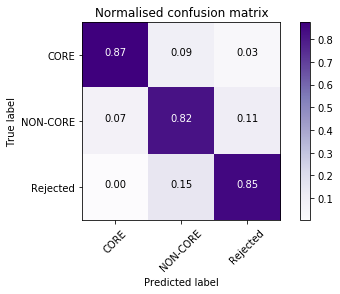

In [21]:
plt.figure()
plot_confusion_matrix(SVC_cm,classes=target_names,normalize=True,title='Normalised confusion matrix')
#plot_confusion_matrix(SVC_cm,classes=target_names,normalize=False,title='Normalised confusion matrix')
plt.show()

In [22]:
inspire_val.insert(2,'prediction',SVC_pred)

In [23]:
df=SVC_clf.decision_function(x_val)



In [25]:
print(df)

[[-0.45473284  1.08928555  2.36544729]
 [ 2.14294753  1.00014328 -0.14309081]
 [ 2.14294753  1.00014328 -0.14309081]
 ...
 [ 2.14294753  1.00014328 -0.14309081]
 [ 2.14294753  1.00014328 -0.14309081]
 [ 2.14294753  1.00014328 -0.14309081]]


In [26]:
inspire_val.insert(2,'decision_core',df[:,0])
inspire_val.insert(2,'decision_nocore',df[:,1])
inspire_val.insert(2,'decision_rej',df[:,2])

In [27]:
inspire_val.head()

,Text,Result,decision_rej,decision_nocore,decision_core,prediction,NC score,core refs,non-core refs,core_ref_refs,non-core_ref_refs,Category
31041,Exploring the new phase transition of CDT This...,2,2.365447,1.089286,-0.454733,2,0,0.941176,0.058824,0.85613,0.04171,hep-th
31042,Optimal Parisian-type dividends payments disco...,0,-0.143091,1.000143,2.142948,0,0,0.000000,0.000000,0.00000,0.00000,math.PR
31043,Strain-induced perpendicular magnetic anisotro...,0,-0.143091,1.000143,2.142948,0,0,0.000000,0.000000,0.00000,0.00000,cond-mat.mtrl-sci
31044,On the Structure of the Bochner-Martinelli Res...,0,-0.143091,1.000143,2.142948,0,0,0.000000,0.000000,0.00000,0.00000,math.CV
31045,Parametrized L-infinity Spaces Motivated by fa...,0,-0.079364,1.028834,2.050530,0,0,0.095238,0.047619,0.03665,0.00452,math.DG


In [28]:
def make_List(Actual, Prediction):
    A1 = inspire_val.loc[(inspire_val['Result'] == Actual) ]   #truly non-core
    out = A1.loc[(A1['prediction'] == Prediction)]  
    return out
    
miss_id=make_List(2,1) 
miss_id.head()

,Text,Result,decision_rej,decision_nocore,decision_core,prediction,NC score,core refs,non-core refs,core_ref_refs,non-core_ref_refs,Category
31064,A parametrix for quantum gravity? In the sixti...,2,1.054947,2.101944,-0.156891,1,0,0.255319,0.148936,0.16143,0.13505,gr-qc
31069,Kinetic Sunyaev-Zeldovich effect in modified g...,2,1.097615,2.260425,-0.358041,1,0,0.368421,0.561404,0.27381,0.52234,astro-ph.CO
31074,Gbit/s Data Transmission on Carbon Fibres Data...,2,1.016360,2.015446,-0.031807,1,0,0.200000,0.000000,0.10492,0.01847,physics.ins-det
31130,The noise properties of 42 millisecond pulsars...,2,1.074569,2.165566,-0.240135,1,1,0.337500,0.325000,0.17467,0.20967,astro-ph.IM
31236,Characterization of foreground emission at deg...,2,1.028044,2.229881,-0.257926,1,0,0.279070,0.418605,0.13204,0.41025,astro-ph.CO


In [29]:
miss_id_cats=miss_id.Category.unique()
print(miss_id_cats)

['gr-qc' 'astro-ph.CO' 'physics.ins-det' 'astro-ph.IM' 'cond-mat.str-el'
 'physics.gen-ph' 'astro-ph.HE' 'math-ph' 'quant-ph' 'astro-ph.GA'
 'cond-mat.stat-mech' 'nucl-th' 'hep-th' 'math.DG' 'astro-ph.SR' 'nucl-ex'
 'cond-mat.quant-gas' 'hep-ph' 'physics.plasm-ph' 'hep-ex'
 'physics.acc-ph' 'astro-ph' 'math.AG' 'cond-mat.mes-hall' 'math.AT']


In [30]:
def count_categories(categories,data):
    for cat in categories:
        count= data['Category'].eq(cat).sum()/len(data)
        yield [cat,count]
        
miss_cat_frac=np.array(list(count_categories(miss_id_cats,miss_id)))
all_cat_frac=np.array(list(count_categories(miss_id_cats,inspire_val)))

In [31]:
#print (miss_cat_frac)

In [32]:
#print(all_cat_frac)

In [38]:
cross_val=cross_val_score(SVC_clf,x_train,y_train,scoring='accuracy',cv=5,n_jobs=-1)

In [ ]:
print (cross_val.mean())

In [33]:
core=inspire.loc[(inspire['Result'] == 2)][['core refs','non-core refs','core_ref_refs','non-core_ref_refs']]
non_core=inspire.loc[(inspire['Result'] == 1) ][['core refs','non-core refs','core_ref_refs','non-core_ref_refs']]
rej=inspire.loc[(inspire['Result'] == 0) ][['core refs','non-core refs','core_ref_refs','non-core_ref_refs']]

In [34]:
def Contour(Gluons,Quarks):
    import seaborn as sns

    Variables=['core refs','non-core refs','core_ref_refs','non-core_ref_refs']
    
    #For reference
    #[0]=JetMass                 USE
    #[1]=Number of particles
    #[2]=TotalCharge
    #[3]=ChargedTracks           USE
    #[4]=Perpmomentum_total      USE
    #[5]=variance
    #[6]=Girth
    #[7]=Anguarities             USE
    #[8]=Rmaxjet                 USE
    #[9]=Rmaxjet phys
    #[10]=theta

    
    i = 0
    j = 3
    sns.set_style("white")
    f, axes = plt.subplots(1)


    sns.kdeplot(core[Variables[i]],core[Variables[j]],cmap='Reds',ax=axes)
    sns.kdeplot(non_core[Variables[i]],non_core[Variables[j]],cmap='Blues',ax=axes)
      
    axes.set(xlabel=Variables[i])
    axes.set(ylabel=Variables[j])
 
    
    axes.plot([],[],color='r',label='CORE')
    axes.plot([],[],color='b',label='NON-CORE')
    axes.legend()

<Figure size 432x288 with 0 Axes>

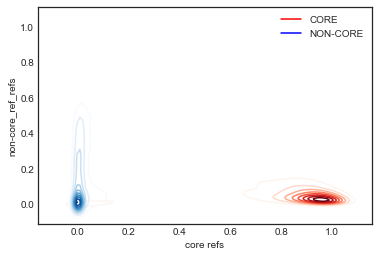

In [35]:
plt.figure()
Contour(core,non_core)
plt.show()

In [36]:
def scatter_plot(X_train,Y_train):
    Variables=['core refs','non-core refs','core_ref_refs','non-core_ref_refs']
    pd.plotting.scatter_matrix(X_train, c=Y_train, figsize=(8,8),marker='o', hist_kwds={'bins':30})
    plt.show()

<Figure size 432x288 with 0 Axes>

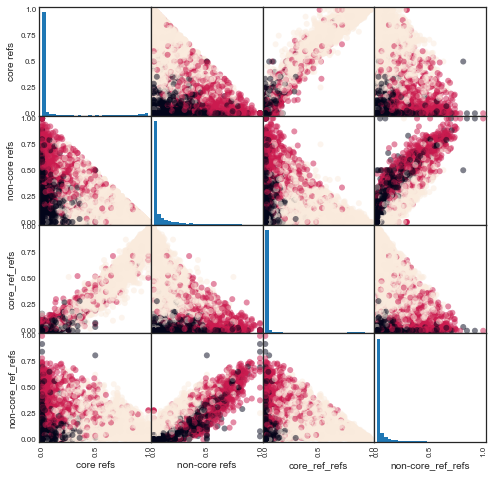

In [37]:
plt.figure()
scatter_plot(x_train,y_train)